In [1]:
#import packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import os

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#set working directory and defaults
os.chdir(os.getcwd()+'/Data')
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)
plt.style.use('ggplot')

In [3]:
#import data sets
score_data = pd.read_csv('score_data_cleaned.csv')
crime_data = pd.read_csv('crime_clus_anomalies.csv')
health_data = pd.read_csv('sociohealth_clus_anomalies.csv')
schools_geo = gpd.read_file('Chicago Public Schools - School Locations SY1718.geojson')
areas_geo = gpd.read_file('Boundaries - Community Areas (current).geojson')

## Scores Analysis

In [4]:
score_data.head()

,Unnamed: 0,School ID,RCDTS,ACT Score,District Name/ School Name,Enrollment,year,commarea,geometry
0,0,609695.0,150162990250001,16.8,Amundsen High School,1547,2011,LINCOLN SQUARE,POINT (-87.67948421494859 41.97506725585589)
1,1,609698.0,150162990250003,15.6,Bogan High School,1748,2011,ASHBURN,POINT (-87.72109744629778 41.74937560933962)
2,2,609760.0,150162990250006,17.0,Carver Military Academy HS,533,2011,RIVERDALE,POINT (-87.59062038515513 41.65628995142258)
3,3,609704.0,150162990250011,16.7,Farragut Career Academy HS,1514,2011,SOUTH LAWNDALE,POINT (-87.70870563225235 41.84855987384877)
4,4,609705.0,150162990250012,14.5,Fenger Academy High School,775,2011,ROSELAND,POINT (-87.63757205080117 41.68995072454672)


In [5]:
scores_grouping = pd.DataFrame(score_data.groupby('School ID')['ACT Score'].mean())
density = gaussian_kde(scores_grouping['ACT Score'])
xs = np.linspace(10,36,200)
density.covariance_factor = lambda : .25
density._compute_covariance()

Text(0, 0.5, 'Kernel Density Estimate')

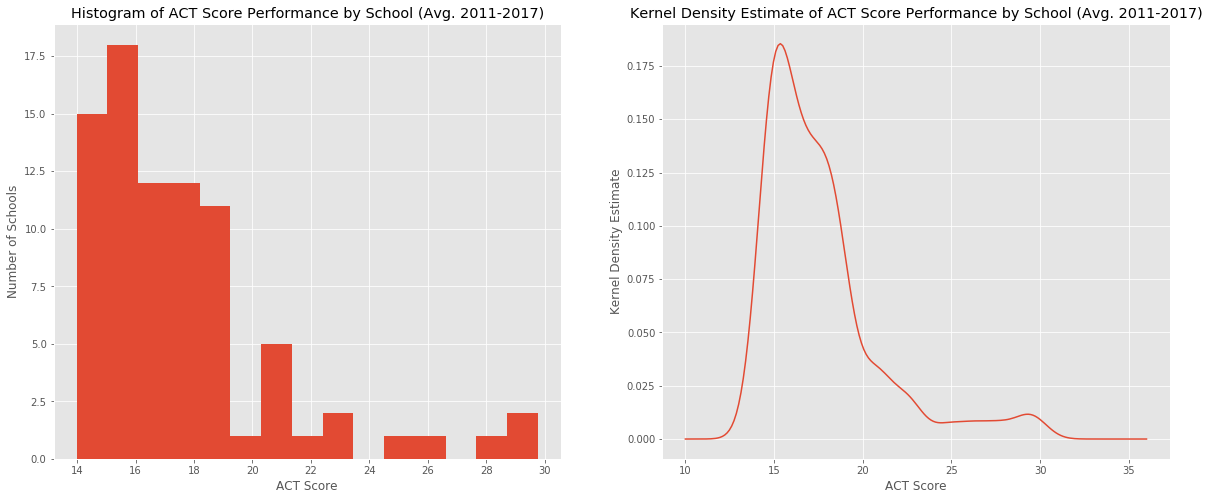

In [6]:
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(121)

ax1.hist(scores_grouping['ACT Score'],bins=15)
ax1.set_title("Histogram of ACT Score Performance by School (Avg. 2011-2017)")
ax1.set_xlabel("ACT Score")
ax1.set_ylabel("Number of Schools")

ax2 = fig.add_subplot(122)

ax2.plot(xs,density(xs))
ax2.set_title("Kernel Density Estimate of ACT Score Performance by School (Avg. 2011-2017)")
ax2.set_xlabel("ACT Score")
ax2.set_ylabel("Kernel Density Estimate")

In [7]:
#set up the quantile score tables
score_avg = pd.DataFrame(score_data.groupby(['School ID','District Name/ School Name','commarea']) \
                             ['ACT Score'].mean())

score_avg['act_quantile'] = pd.qcut(score_avg['ACT Score'],5,labels=False)
score_quant_aggs = score_avg.groupby('act_quantile')['ACT Score'] \
.agg(['mean','count','median','min','max'])

In [8]:
score_quant_aggs

,mean,count,median,min,max
act_quantile,,,,,
0,14.660175,19,14.70,13.983333,14.966667
1,15.509211,19,15.40,15.050000,16.133333
2,16.821053,19,16.76,16.200000,17.566667
3,18.223860,19,18.25,17.600000,18.860000
4,22.502632,19,21.00,18.983333,29.766667


In [54]:
score_avg.head()

,School ID,District Name/ School Name_x,commarea_x,ACT Score_x,act_quantile
0,609674.0,Chicago Vocational Career Acad HS,AVALON PARK,14.950000,0
1,609676.0,Dunbar Vocational Career Acad HS,DOUGLAS,14.933333,0
2,609678.0,Jones College Prep High School,LOOP,26.250000,4
3,609679.0,Prosser Career Academy HS,BELMONT CRAGIN,18.300000,3
4,609680.0,Payton College Preparatory HS,NEAR NORTH SIDE,29.133333,4


In [55]:
score_avg['ACT Score_x'].median()

16.76

(0, 36)

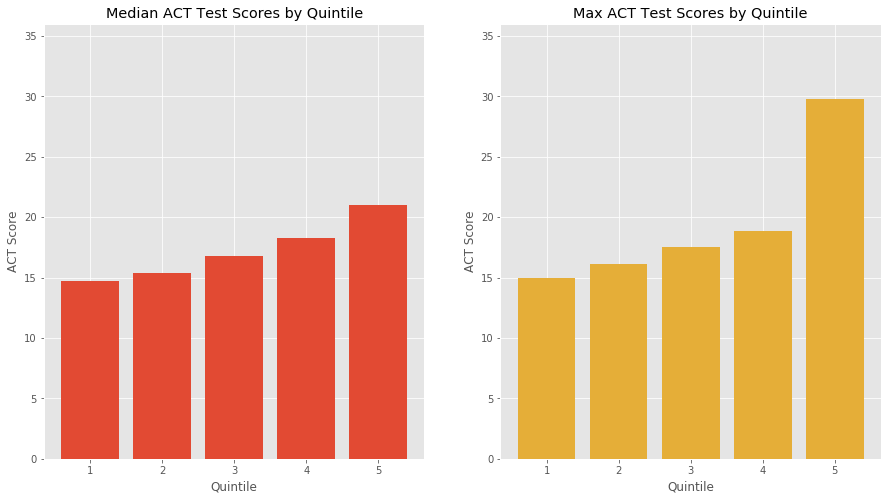

In [51]:
#graph of quantile stats

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(121)

ax1.bar(x=score_quant_aggs.index,height=score_quant_aggs['median'],tick_label=[1,2,3,4,5])
ax1.set_title("Median ACT Test Scores by Quintile")
ax1.set_xlabel("Quintile")
ax1.set_ylabel("ACT Score")
ax1.set_ylim(0,36)

ax2 = fig.add_subplot(122)
ax2.bar(x=score_quant_aggs.index,height=score_quant_aggs['max'],tick_label=[1,2,3,4,5],color='#e5ae38')
ax2.set_title("Max ACT Test Scores by Quintile")
ax2.set_xlabel("Quintile")
ax2.set_ylabel("ACT Score")
ax2.set_ylim(0,36)

In [10]:
#graph showing performance varies by community area
score_avg.reset_index(inplace=True)

In [11]:
score_avg = pd.merge(left=score_avg,right=score_data[score_data['year']==2011],
                     how='left',left_on='School ID',right_on='School ID')

score_avg = score_avg[['School ID', 'District Name/ School Name_x', 'commarea_x',
       'ACT Score_x', 'act_quantile']]

schools_geo['school_id_num'] = schools_geo['school_id'].astype(float)

scores_geo = pd.merge(left=schools_geo,right=score_avg,how='left'
                      ,left_on='school_id_num',right_on='School ID')

Text(0.5, 1.0, 'Quintile of Average ACT Scores by School')

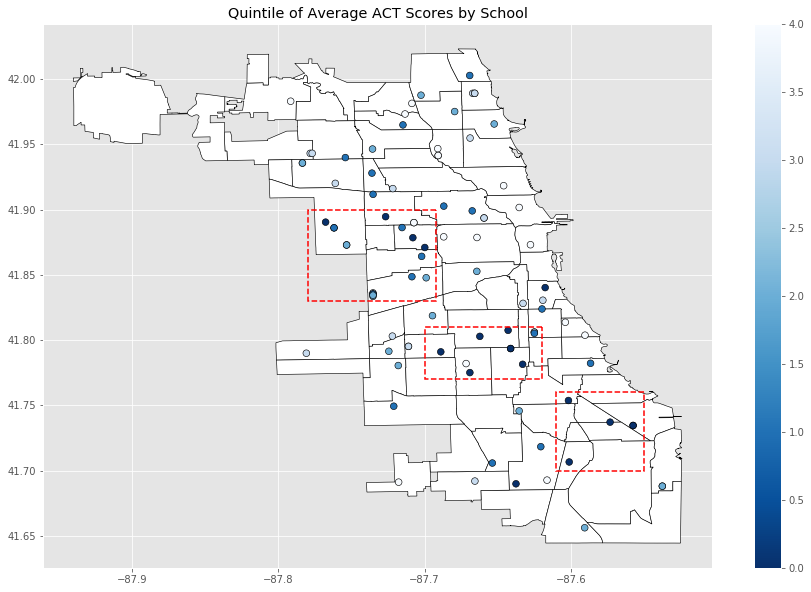

In [12]:
import matplotlib.patches as patches
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

areas_geo.plot(column=None,cmap=None,color='white',ax=ax,edgecolor='black',linewidth=0.6)

scores_geo.plot(column='act_quantile',cmap='Blues_r',ax=ax,
                edgecolor='black',linewidth=0.6,legend=True,markersize=45)

poly = Polygon([(-87.692,41.9),(-87.78,41.9),(-87.78,41.83),(-87.692,41.83)],
               facecolor='None',edgecolor='red',linewidth=1.5,linestyle='--')

poly2 = Polygon([(-87.62,41.81),(-87.7,41.81),(-87.7,41.77),(-87.62,41.77)],
               facecolor='None',edgecolor='red',linewidth=1.5,linestyle='--')

poly3 = Polygon([(-87.55,41.76),(-87.61,41.76),(-87.61,41.7),(-87.55,41.7)],
               facecolor='None',edgecolor='red',linewidth=1.5,linestyle='--')

# Add the patch to the Axes
ax.add_patch(poly)
ax.add_patch(poly2)
ax.add_patch(poly3)
ax.set_title("Quintile of Average ACT Scores by School")

### Join Crime and ACT

In [14]:
#join to get community area id number
score_data = pd.merge(left=score_data,right=areas_geo,how='left',left_on='commarea',right_on='community')

In [15]:
#keep only needed columns
score_data = score_data[['School ID', 'ACT Score','District Name/ School Name',' Enrollment ',
                         'year', 'commarea','geometry_x','area_num_1','community']]

score_data['area_num_1'] = score_data['area_num_1'].astype(int)

#join to crime data
score_crime = pd.merge(left=score_data,right=crime_data,how='left',
                       left_on='area_num_1',right_on='commarea')

In [16]:
score_crime.shape

(477, 42)

In [17]:
score_crime.dropna(inplace=True) #drop where there was community area no crime data

In [18]:
score_crime['cluster'].unique()

array([1., 0., 3.])

### Crime Cluster Analysis

In [19]:
#import elbow values and silhouette scores from other notebook for plotting here
elbows = [2.9203498768583827,
         2.57894962435732,
         2.3985377268371284,
         2.2725366760724497,
         2.149758972891493,
         2.048562457553399,
         1.9220495073378574,
         1.8229741996323139,
         1.7656636724813553,
         1.6841106493170444,
         1.6125566610062427,
         1.5710956120511363,
         1.5052391937052687]

scores = [0.47917286020426514,
         0.41883599955752304,
         0.414608147003916,
         0.42388517047415203,
         0.4176832616076343,
         0.41709298428441893,
         0.24335967218382146,
         0.1699546939232783,
         0.20848795060878567,
         0.16153619859533488,
         0.20910546058122356,
         0.19752571975424024,
         0.19011342981646565]

x = [2,3,4,5,6,7,8,9,10,11,12,13,14]

Text(0, 0.5, 'Mean Square Error')

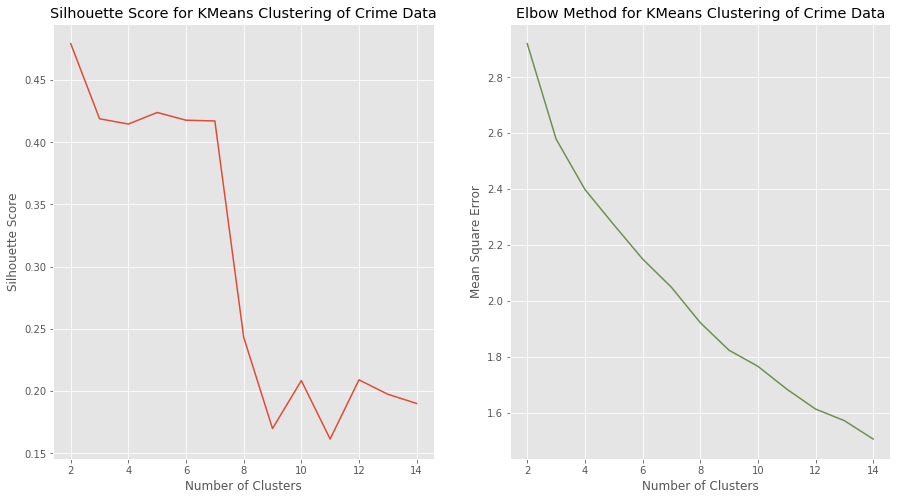

In [20]:
fig = plt.figure(figsize(15,8))
ax = fig.add_subplot(121)

ax.plot(x,scores)
ax.set_title("Silhouette Score for KMeans Clustering of Crime Data")
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Silhouette Score")

ax1 = fig.add_subplot(122)

ax1.plot(x,elbows,color='#6d904f')
ax1.set_title("Elbow Method for KMeans Clustering of Crime Data")
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Mean Square Error")

In [21]:
crime_list = ['ARSON', 'ASSAULT AND BATTERY', 'BURGLARY',
       'CRIMINAL DAMAGE', 'DECEPTIVE PRACTICE', 'GAMBLING', 'HOMICIDE',
       'INTERFERENCE WITH PUBLIC OFFICER', 'INTIMIDATION', 'KIDNAPPING',
       'LIQUOR LAW VIOLATION', 'NARCOTICS', 'OFFENSE INVOLVING CHILDREN',
       'OTHER OFFENSE', 'PROSTITUTION', 'PUBLIC PEACE VIOLATION', 'ROBBERY',
       'SEXUAL ASSAULT', 'STALKING', 'THEFT', 'TRESPASSING', 'VEHICLE THEFT',
       'WEAPONS VIOLATION',]

In [22]:
crime_data['all_crime'] = crime_data[crime_list].sum(axis=1)

In [23]:
#adjust cluster values for mapping
def change_clus(row):
    if row == 0:
        row = 1
    elif row == 1:
        row = 0
    elif row == 2:
        row = 3
    else:
        row = 2
    return row
        
crime_data['cluster_scaled'] = crime_data['cluster'].apply(lambda row: change_clus(row))

In [24]:
areas_geo['area_num_1'] = areas_geo['area_num_1'].astype(int)

In [25]:
#join crime and geographic data 
crime_geo = pd.merge(left=areas_geo,right=crime_data, how='left',
                     left_on='area_num_1',right_on='commarea')

In [26]:
crime_geo = crime_geo[['geometry',
       'Unnamed: 0', 'commarea', 'ARSON', 'ASSAULT AND BATTERY', 'BURGLARY',
       'CRIMINAL DAMAGE', 'DECEPTIVE PRACTICE', 'GAMBLING', 'HOMICIDE',
       'INTERFERENCE WITH PUBLIC OFFICER', 'INTIMIDATION', 'KIDNAPPING',
       'LIQUOR LAW VIOLATION', 'NARCOTICS', 'OFFENSE INVOLVING CHILDREN',
       'OTHER OFFENSE', 'PROSTITUTION', 'PUBLIC PEACE VIOLATION', 'ROBBERY',
       'SEXUAL ASSAULT', 'STALKING', 'THEFT', 'TRESPASSING', 'VEHICLE THEFT',
       'WEAPONS VIOLATION', '0', 'commarea_x', 'dist_0', 'dist_1', 'dist_2',
       'dist_3', 'cluster', 'dist_to_clus', 'all_crime', 'cluster_scaled']]

/nfshome/cb4102/.conda/envs/deeplearn/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Text(0.5, 1.0, 'Crime Clusters and School Locations by ACT Performance Quintile')

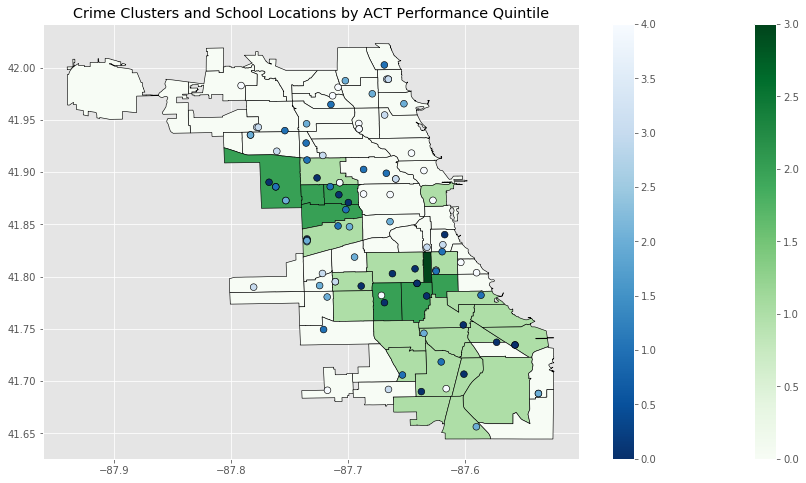

In [27]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)

crime_geo.plot(column='cluster_scaled',
               cmap='Greens',ax=ax,legend=True,edgecolor='black',linewidth=0.6)

scores_geo.plot(column='act_quantile',cmap='Blues_r',ax=ax,
                edgecolor='black',linewidth=0.6,legend=True,markersize=45)

ax.set_title("Crime Clusters and School Locations by ACT Performance Quintile")


## Crime and ACT Graphs

In [28]:
score_agg = score_data.groupby('area_num_1')['ACT Score'].agg(['mean','median','max','min'])

In [29]:
score_crime = pd.merge(left=score_agg,right=crime_data,how='left',
                       left_on='area_num_1',right_on='commarea')

In [30]:
crime_clus_aggs = pd.DataFrame(score_crime.groupby(['cluster_scaled'])['mean'].mean())

Text(-4.75, 3.3, 'Correlation = -0.41')

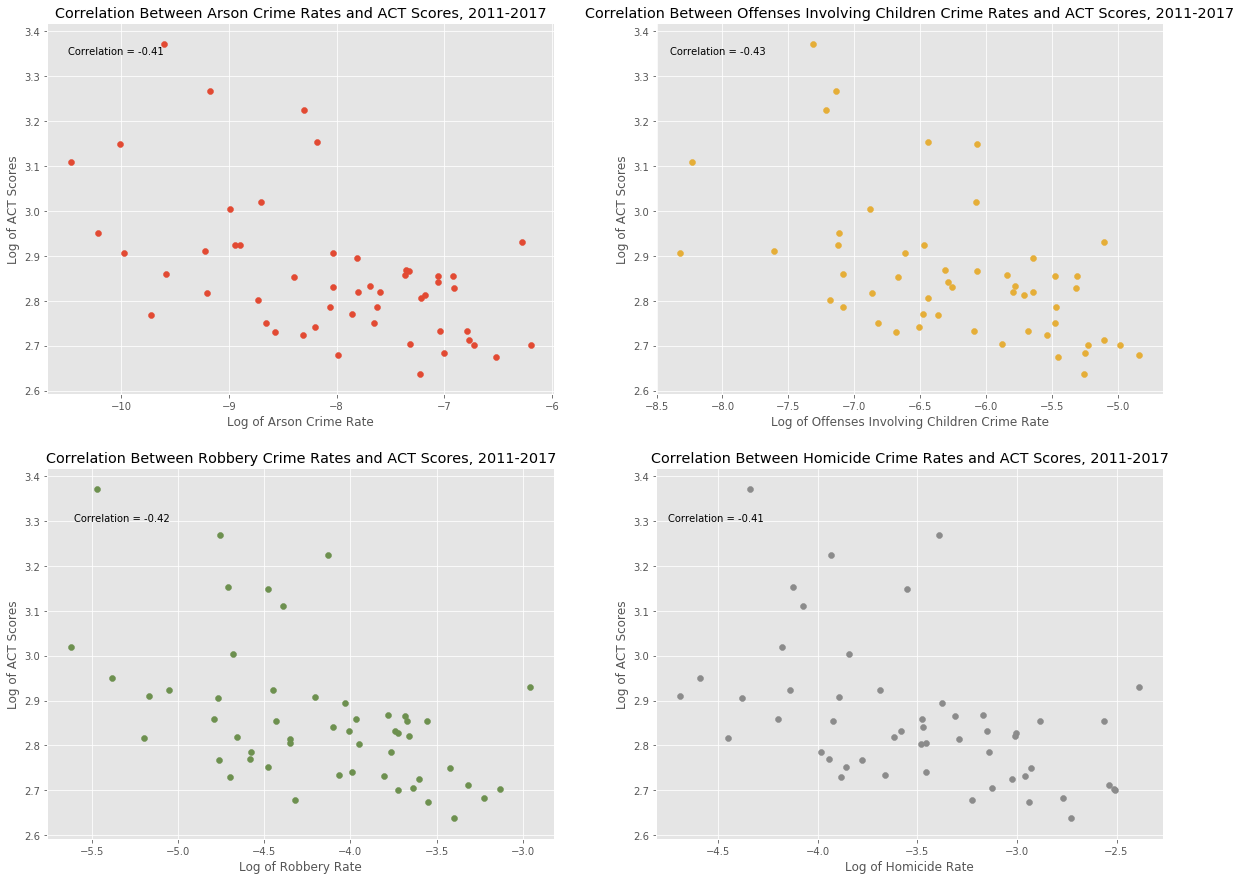

In [31]:
#Make a set of scatter plots for the highest correlation crime rates
fig = plt.figure(figsize(20,15))
ax1 = fig.add_subplot(221)

ax1.scatter(np.log(score_crime['ARSON']),np.log(score_crime['mean']))
ax1.set_title("Correlation Between Arson Crime Rates and ACT Scores, 2011-2017")
ax1.set_xlabel("Log of Arson Crime Rate")
ax1.set_ylabel("Log of ACT Scores")
ax1.text(s="Correlation = -0.41",x= -10.5,y= 3.35)

ax2 = fig.add_subplot(222)

ax2.scatter(np.log(score_crime['OFFENSE INVOLVING CHILDREN']),np.log(score_crime['mean']),color='#e5ae38')
ax2.set_title("Correlation Between Offenses Involving Children Crime Rates and ACT Scores, 2011-2017")
ax2.set_xlabel("Log of Offenses Involving Children Crime Rate")
ax2.set_ylabel("Log of ACT Scores")
ax2.text(s="Correlation = -0.43",x= -8.4,y= 3.35)


ax3 = fig.add_subplot(223)

ax3.scatter(np.log(score_crime['BURGLARY']),np.log(score_crime['mean']),color='#6d904f')
ax3.set_title("Correlation Between Robbery Crime Rates and ACT Scores, 2011-2017")
ax3.set_xlabel("Log of Robbery Rate")
ax3.set_ylabel("Log of ACT Scores")
ax3.text(s="Correlation = -0.42",x= -5.6,y= 3.3)

ax4 = fig.add_subplot(224)

ax4.scatter(np.log(score_crime['CRIMINAL DAMAGE']),np.log(score_crime['mean']),color='#8b8b8b')
ax4.set_title("Correlation Between Homicide Crime Rates and ACT Scores, 2011-2017")
ax4.set_xlabel("Log of Homicide Rate")
ax4.set_ylabel("Log of ACT Scores")
ax4.text(s="Correlation = -0.41",x= -4.75,y=3.3)


### Health Cluster Analysis

In [32]:
#import elbows and silhouette scores from health cluster notebook for graphing
scores = [0.3423426675859131,
         0.30001775456499347,
         0.25738426424833316,
         0.18869454425413498,
         0.1691462954114385,
         0.17733050162794609,
         0.15274412208363117,
         0.15125150953806152,
         0.18646196106878132,
         0.1660680413855916,
         0.16626658702230337,
         0.15070415180143923,
         0.14279914283363682]

elbows = [4.314034911600178,
         3.8032344716087043,
         3.576683668231266,
         3.4348157227199447,
         3.3146769778676046,
         3.1815252220944292,
         3.1244301874518956,
         3.0359631743029705,
         2.951988384304625,
         2.831435787687643,
         2.750014464615402,
         2.651562280230894,
         2.6278634688778313]

Text(0, 0.5, 'Mean Square Error')

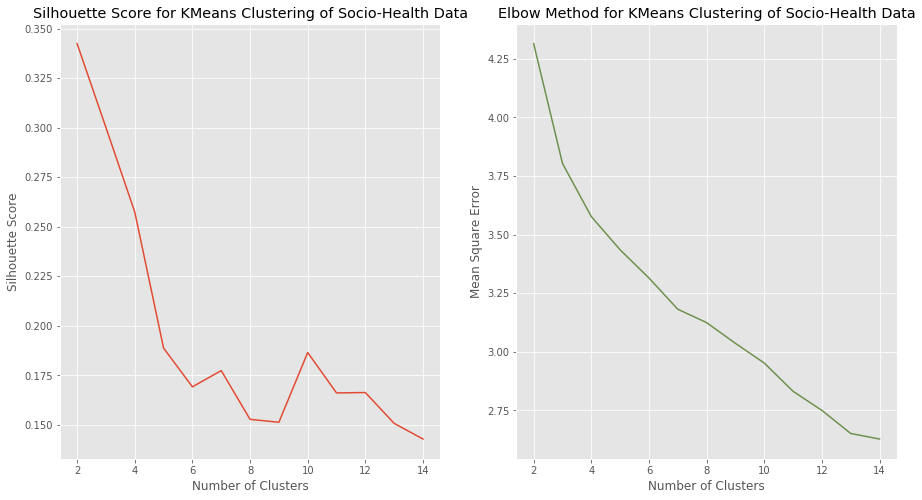

In [33]:
fig = plt.figure(figsize(15,8))
ax = fig.add_subplot(121)

ax.plot(x,scores)
ax.set_title("Silhouette Score for KMeans Clustering of Socio-Health Data")
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Silhouette Score")

ax1 = fig.add_subplot(122)

ax1.plot(x,elbows,color='#6d904f')
ax1.set_title("Elbow Method for KMeans Clustering of Socio-Health Data")
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Mean Square Error")

## Health and ACT Graphs

In [34]:
health_data.head()

,Unnamed: 0,Community Area,Community Area Name,Birth Rate,General Fertility Rate,Low Birth Weight,Prenatal Care Beginning in First Trimester,Preterm Births,Teen Birth Rate,Assault (Homicide),Breast cancer in females,Cancer (All Sites),Colorectal Cancer,Diabetes-related,Firearm-related,Infant Mortality Rate,Lung Cancer,Prostate Cancer in Males,Stroke (Cerebrovascular Disease),Childhood Blood Lead Level Screening,Childhood Lead Poisoning,Gonorrhea in Females,Gonorrhea in Males,Tuberculosis,Below Poverty Level,Crowded Housing,Dependency,No High School Diploma,Per Capita Income,Unemployment,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,0,geometry,dist_0,dist_1,dist_2,dist_3,cluster,dist_to_clus
0,0,1,Rogers Park,16.4,62.0,11.0,73.0,11.2,40.8,7.7,23.3,176.9,25.3,77.1,5.2,6.4,36.7,21.7,33.7,364.7,0.5,322.5,423.3,11.4,22.7,7.9,28.8,18.1,23714,7.5,7.7,23.6,8.7,18.2,27.5,23939,39.0,1,MULTIPOLYGON (((-87.65455590025104 41.99816614...,4.534783,4.185623,7.517696,4.766690,1,4.185623
1,1,2,West Ridge,17.3,83.3,8.1,71.1,8.3,29.9,5.8,20.2,155.9,17.3,60.5,3.7,5.1,36.0,14.2,34.7,331.4,1.0,141.0,205.7,8.9,15.1,7.0,38.3,19.6,21375,7.9,7.8,17.2,8.8,20.8,38.5,23040,46.0,1,MULTIPOLYGON (((-87.6846530946559 42.019484772...,4.356164,3.397217,8.249658,5.522805,1,3.397217
2,2,3,Uptown,13.1,50.5,8.3,77.7,10.3,35.1,5.4,21.3,183.3,20.5,80.0,4.6,6.5,50.5,25.2,41.7,353.7,0.5,170.8,468.7,13.6,22.7,4.6,22.2,13.6,32355,7.7,3.8,24.0,8.9,11.8,22.2,35787,20.0,3,MULTIPOLYGON (((-87.64102430213292 41.95480280...,4.492047,6.127019,8.394754,3.278240,3,3.278240
3,3,4,Lincoln Square,17.1,61.0,8.1,80.5,9.7,38.4,5.0,21.7,153.2,8.6,55.4,6.1,3.8,43.1,27.6,36.9,273.3,0.4,98.8,195.5,8.5,9.5,3.1,25.6,12.5,35503,6.8,3.4,10.9,8.2,13.4,25.5,37524,17.0,3,MULTIPOLYGON (((-87.6744075678037 41.976103404...,3.832416,6.014628,9.476830,2.182429,3,2.182429
4,4,5,North Center,22.4,76.2,9.1,80.4,9.8,8.4,1.0,16.6,152.1,26.1,49.8,1.0,2.7,42.4,15.1,41.6,178.1,0.9,85.4,188.6,1.9,7.1,0.2,25.5,5.4,51615,4.5,0.3,7.5,5.2,4.5,26.2,57123,6.0,3,MULTIPOLYGON (((-87.67336415409336 41.93234274...,5.429909,8.453495,10.966693,3.931643,3,3.931643


In [35]:
#aggregate scores to school level
score_agg = pd.DataFrame(score_data.groupby(['School ID','area_num_1'])['ACT Score'] \
                         .agg(['mean','median','min','max']))

score_agg.reset_index(inplace=True)

In [36]:
#join community area data to schools

score_agg = pd.merge(left=score_agg,right=health_data,how='left',
                     left_on='area_num_1',right_on='Community Area')

Text(0.25, 3.35, 'Correlation = -0.52')

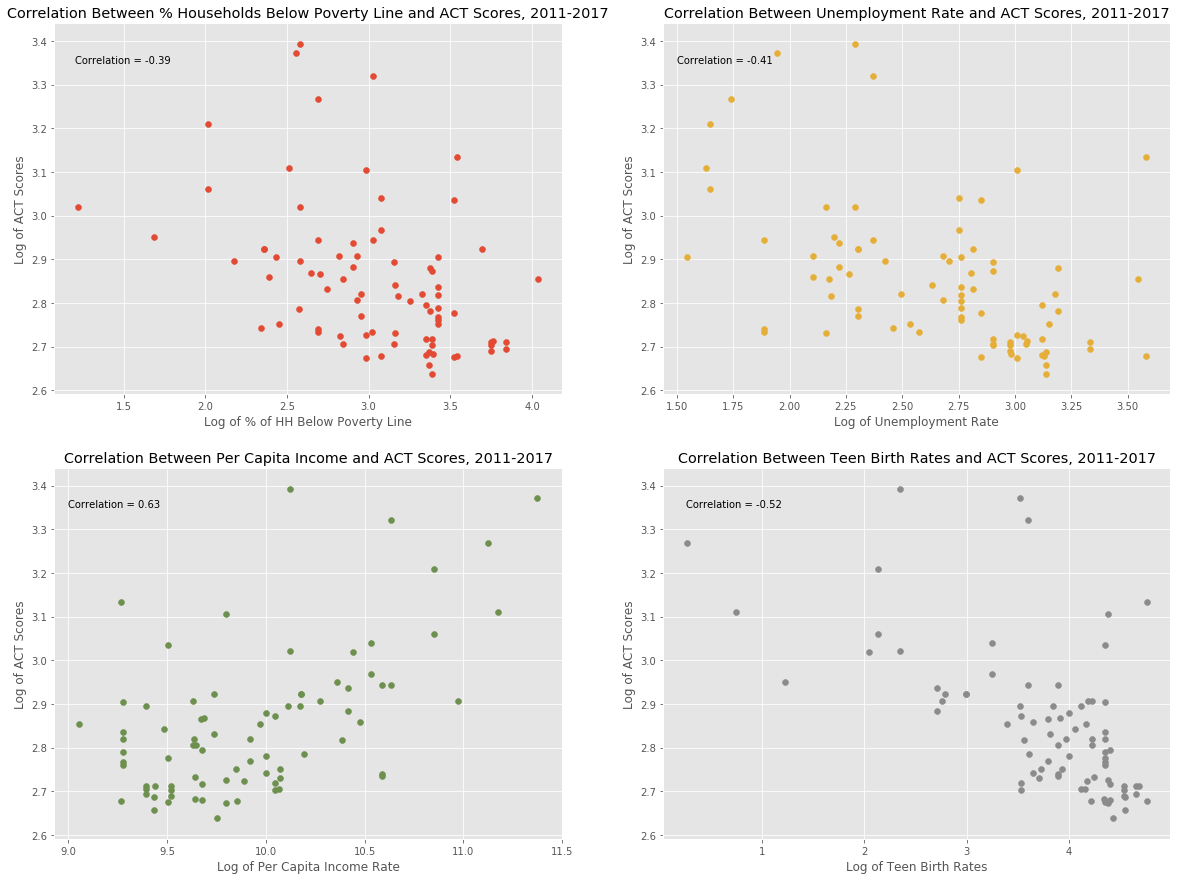

In [37]:
#Make a set of scatter plots for the highest correlation crime rates
fig = plt.figure(figsize(20,15))
ax1 = fig.add_subplot(221)

ax1.scatter(np.log(score_agg['PERCENT HOUSEHOLDS BELOW POVERTY']),np.log(score_agg['mean']))
ax1.set_title("Correlation Between % Households Below Poverty Line and ACT Scores, 2011-2017")
ax1.set_xlabel("Log of % of HH Below Poverty Line")
ax1.set_ylabel("Log of ACT Scores")
ax1.text(s="Correlation = -0.39",x= 1.2,y= 3.35)

ax2 = fig.add_subplot(222)

ax2.scatter(np.log(score_agg['PERCENT AGED 16+ UNEMPLOYED']),np.log(score_agg['mean']),color='#e5ae38')
ax2.set_title("Correlation Between Unemployment Rate and ACT Scores, 2011-2017")
ax2.set_xlabel("Log of Unemployment Rate")
ax2.set_ylabel("Log of ACT Scores")
ax2.text(s="Correlation = -0.41",x=1.5,y= 3.35)


ax3 = fig.add_subplot(223)

ax3.scatter(np.log(score_agg['Per Capita Income']),np.log(score_agg['mean']),color='#6d904f')
ax3.set_title("Correlation Between Per Capita Income and ACT Scores, 2011-2017")
ax3.set_xlabel("Log of Per Capita Income Rate")
ax3.set_ylabel("Log of ACT Scores")
ax3.text(s="Correlation = 0.63",x= 9,y= 3.35)

ax4 = fig.add_subplot(224)

ax4.scatter(np.log(score_agg['Teen Birth Rate']),np.log(score_agg['mean']),color='#8b8b8b')
ax4.set_title("Correlation Between Teen Birth Rates and ACT Scores, 2011-2017")
ax4.set_xlabel("Log of Teen Birth Rates")
ax4.set_ylabel("Log of ACT Scores")
ax4.text(s="Correlation = -0.52",x= 0.25,y=3.35)

In [38]:
score_agg.groupby('cluster')['mean'].mean()

cluster
0    19.306410
1    16.673013
2    15.932963
3    20.493021
Name: mean, dtype: float64

In [39]:
areas_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 10 columns):
community     77 non-null object
area          77 non-null object
shape_area    77 non-null object
perimeter     77 non-null object
area_num_1    77 non-null int64
area_numbe    77 non-null object
comarea_id    77 non-null object
comarea       77 non-null object
shape_len     77 non-null object
geometry      77 non-null object
dtypes: int64(1), object(9)
memory usage: 6.1+ KB


In [40]:
#join for geometries
score_agg_geo = pd.merge(left=areas_geo,right=score_agg,left_on='area_num_1',
                                     right_on='area_num_1',how='left')

In [41]:
score_agg_geo.rename({'geometry_x':'geometry'},axis=1,inplace=True)

/nfshome/cb4102/.conda/envs/deeplearn/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Text(0.5, 1.0, 'Socio-Health Clusters and School ACT Performance')

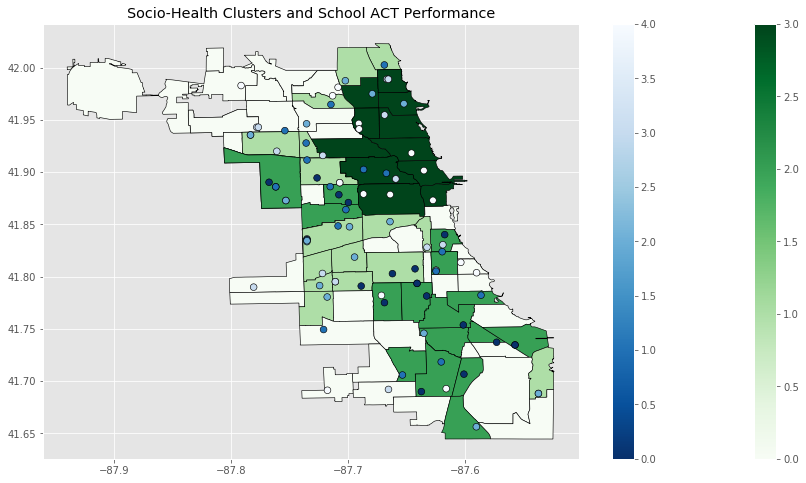

In [42]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)

score_agg_geo.plot(column='cluster',
               cmap='Greens',ax=ax,legend=True,edgecolor='black',linewidth=0.6)

scores_geo.plot(column='act_quantile',cmap='Blues_r',ax=ax,
                edgecolor='black',linewidth=0.6,legend=True,markersize=45)

ax.set_title("Socio-Health Clusters and School ACT Performance")

### School Analysis

In [43]:
school_perf = pd.read_csv('final_school.csv')

In [44]:
school_perf.head()

,Small,Neighborhood,Military academy,Magnet,Career academy,Selective enrollment,enrollment,ACT Score,college_enr_pct,dropout_pct,student_att,fy_on_track_pct,teacher_att,commarea,school_id,geometry,year,name,cluster,x,y
0,0,1,0,0,0,0,1485,15.4,0.3965,0.0175,0.8365,0.7330,0.9445,PORTAGE PARK,609708,POINT (-87.75416654390553 41.93979676728623),2013,Edwin G Foreman High School,1,-87.754167,41.939797
1,0,0,0,0,1,0,979,14.9,0.5240,0.0360,0.8210,0.7760,0.9475,AVALON PARK,609674,POINT (-87.57326751568073 41.73717393358173),2013,Chicago Vocational Career Academy High School,2,-87.573268,41.737174
2,0,0,0,0,1,0,1112,15.0,0.6500,0.0145,0.8110,0.7140,0.9550,DOUGLAS,609676,POINT (-87.61763743460318 41.84022557168194),2013,Paul Laurence Dunbar Career Academy High School,1,-87.617637,41.840226
3,0,0,0,0,0,1,1086,26.5,0.8815,0.0125,0.9365,0.9830,0.9520,LOOP,609678,POINT (-87.62767532291659 41.87306592282553),2013,William Jones College Preparatory High School,3,-87.627675,41.873066
4,0,0,0,0,1,0,1478,18.6,0.5895,0.0210,0.8705,0.8395,0.9470,BELMONT CRAGIN,609679,POINT (-87.76104831561555 41.92005939899792),2013,Charles Allen Prosser Career Academy High School,1,-87.761048,41.920059


Text(0.5, 1.0, 'Median ACT Score by School Quality Cluster')

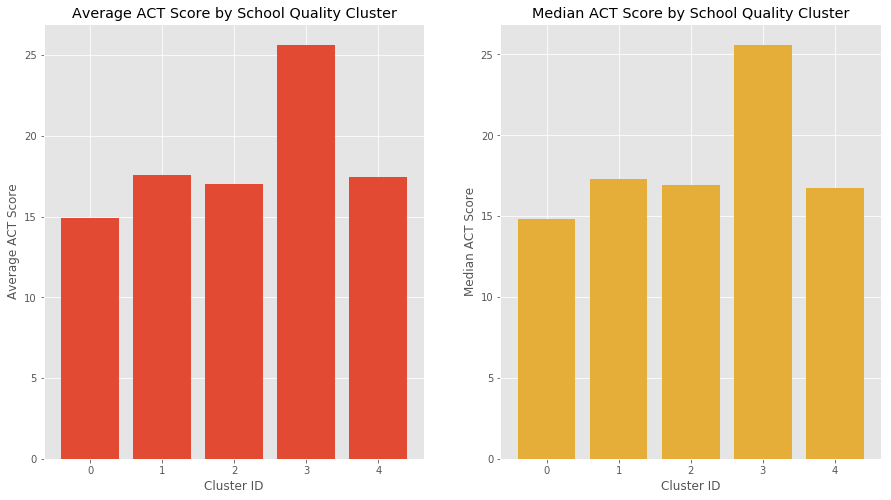

In [50]:
schools_agg = pd.DataFrame(school_perf.groupby(['cluster'])['ACT Score'] \
             .agg(['mean','median']))

fig = plt.figure(figsize=(15,8))

ax = fig.add_subplot(121)

ax.bar(x=[0,1,2,3,4],height=schools_agg['mean'])

ax.set_xlabel("Cluster ID")
ax.set_ylabel("Average ACT Score")
ax.set_title("Average ACT Score by School Quality Cluster")

ax1 = fig.add_subplot(122)

ax1.bar(x=[0,1,2,3,4],height=schools_agg['median'],color='#e5ae38')

ax1.set_xlabel("Cluster ID")
ax1.set_ylabel("Median ACT Score")
ax1.set_title("Median ACT Score by School Quality Cluster")

In [ ]:
['Small', 'Neighborhood', 'Military academy', 'Magnet', 'Career academy',
       'Selective enrollment', 'enrollment', 'ACT Score', 'college_enr_pct',
       'dropout_pct', 'student_att', 'fy_on_track_pct', 'teacher_att',
       'commarea','cluster',